### Notebook exploring how to create patches in PyTorch
#### Focused on an example image

In [1]:
import matplotlib.pyplot as plt
from openslide import open_slide
import numpy as np
from PIL import Image
import os
import torch
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image

Image.MAX_IMAGE_PIXELS = None

In [2]:
# Read in example WSI
SVS_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/raw/svs_files/'
svs_files = os.listdir(SVS_DIR)
svs_file = SVS_DIR + svs_files[0]
slide = open_slide(svs_file)
FILE_NAME=svs_file.replace('.svs', '').replace(SVS_DIR, '')

In [3]:
# Get 10X thumbnail of slide to work with
slide_props = slide.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height'])
slide10X = np.array(slide.get_thumbnail(size=(slide_width, slide_height)))

In [4]:
# Read in example labelled image
MASK_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/interim/masks/'
mask_file = MASK_DIR + FILE_NAME + '.png'
mask = np.array(Image.open(mask_file))
# reshape mask file to be same size as SVS
mask = mask[:slide10X.shape[0], :slide10X.shape[1]]

In [6]:
# Check they are the same shapes
print(slide_width, slide_height)
print(slide10X.shape)
print(len(mask.shape))
print(mask.shape) # height, width ?

33557 23395
(23395, 33557, 3)
2
(23395, 33557)


Text(0.5, 1.0, 'Segmentation mask')

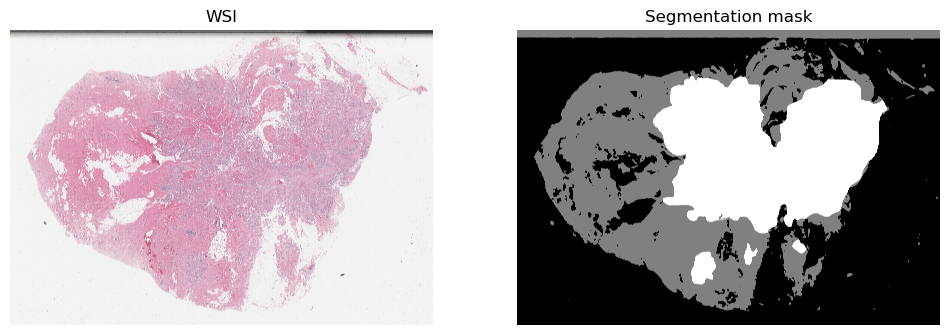

In [105]:
# Visually confirm that we are working with corresponding images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(slide10X); ax1.axis('off'); ax1.set_title("WSI")
ax2.imshow(mask, cmap="gray"); ax2.axis('off'); ax2.set_title("Segmentation mask")

## Testing my functions

In [5]:
import sys
sys.path.append('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/src/')
from data.preprocessing import *

In [6]:
PATCH_SIZE=5000
STRIDE=PATCH_SIZE

In [19]:
print(slide10X.shape)

(23395, 33557, 3)


In [7]:
im_patches = image_to_patches(slide10X, PATCH_SIZE, STRIDE)

In [21]:
print(im_patches.shape)

torch.Size([24, 3, 5000, 5000])


In [22]:
first_patch = im_patches[0, :, :, :]
print(first_patch.shape)

i = 3
ith_patch = im_patches[i, :, :, :]

torch.Size([3, 5000, 5000])


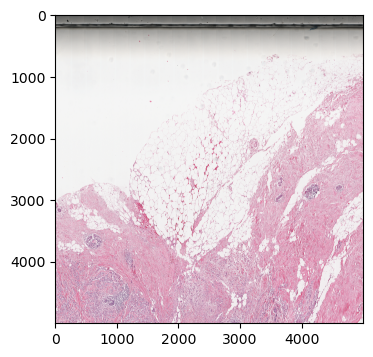

In [23]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(ith_patch.numpy(), (1, 2, 0)))

In [8]:
mask_patches = image_to_patches(mask, PATCH_SIZE, STRIDE)

print(mask_patches.shape)

torch.Size([24, 5000, 5000])


In [8]:
first_m_patch = mask_patches[0, :, :]
print(first_m_patch.shape)

i = 3
ith_m_patch = mask_patches[i, :, :]

torch.Size([5000, 5000])


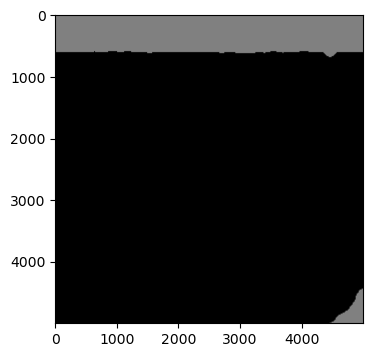

In [29]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(first_m_patch.numpy(), cmap="gray", vmin=0, vmax=1)

In [11]:
# Troubleshooting the function for binary images
unique_values, unique_indices = torch.unique(first_m_patch, return_inverse=True)
print("Unique values:", unique_values)
print("Number of unique values:", len(unique_values))

Unique values: tensor([0.0000, 0.5000])
Number of unique values: 2


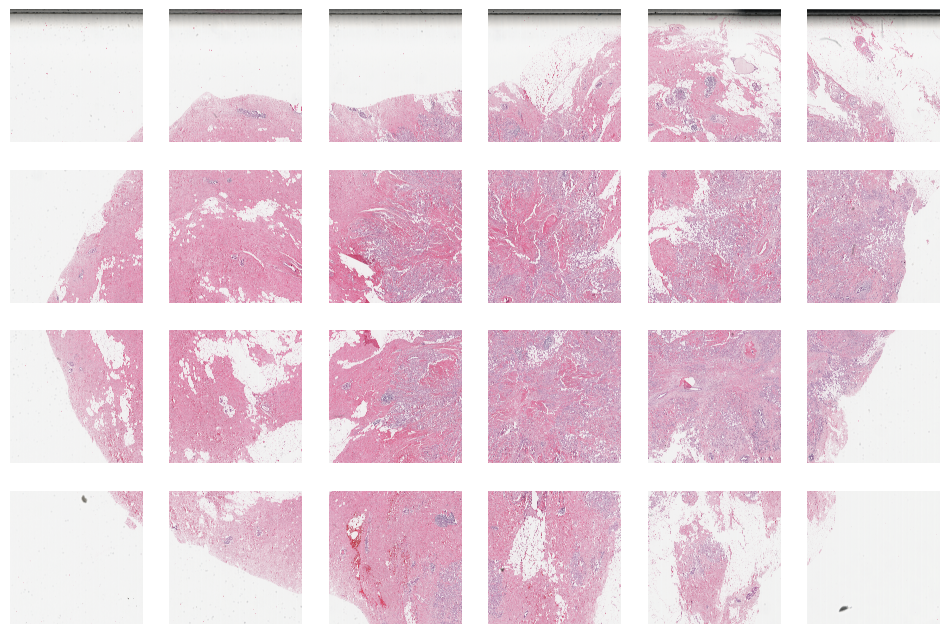

In [27]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axs = axes.ravel()
for i, ax in enumerate(axs):
    ax.imshow(np.transpose(im_patches[i, :, :, :].numpy(), (1, 2, 0)))
    ax.axis('off')

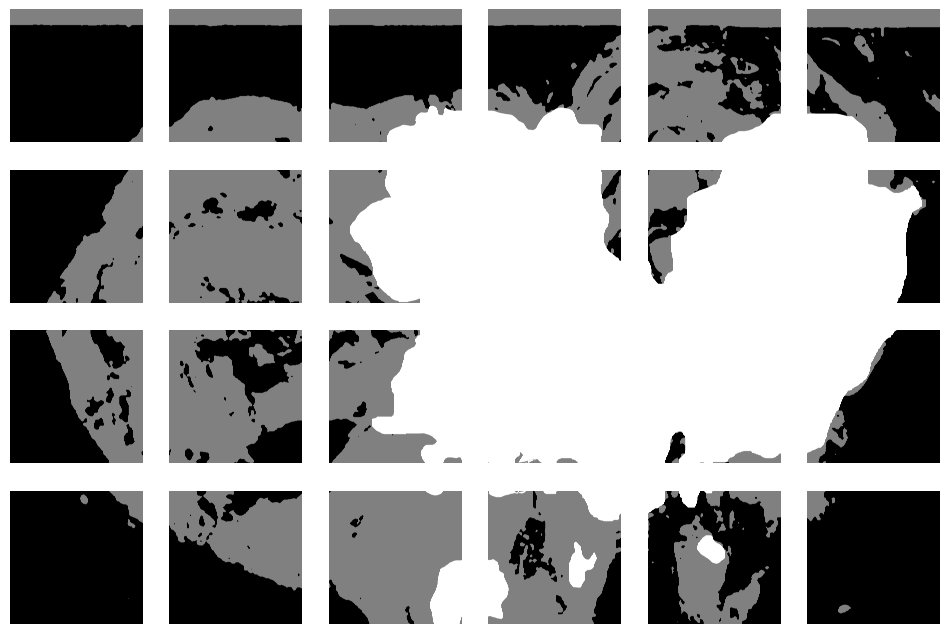

In [9]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axs = axes.ravel()
for i, ax in enumerate(axs):
    ax.imshow(mask_patches[i, :, :].numpy(), cmap="gray", vmin=0, vmax=1)
    ax.axis('off')

In [10]:
# Testing 'discard' function
tissue_patches, seg_patches = discard_background_patches(im_patches, mask_patches, PATCH_SIZE)

TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)
